# Classification

Notebook for classification tasks

Plan:
- Load data
- Train/test split
- Baseline model (Logistic Regression)
- Metrics: accuracy, precision, recall, F1, ROC-AUC


In [29]:
# Я начинаю проект: подключаю базовые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    roc_auc_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)

In [30]:
# Загружаю train.csv
df = pd.read_csv("train.csv")

# Смотрю размер (строки, столбцы)
print("Размер df:", df.shape)

# Смотрю первые строки
df.head()

Размер df: (145879, 59)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9.0,1.0,5.0,8.0,0.0,1.0,1.0,0.0,0.0,1.0
1,9,0,1,1,7,0,0,0,0,1,...,3.0,1.0,1.0,9.0,0.0,1.0,1.0,0.0,1.0,0.0
2,13,0,5,4,9,1,0,0,0,1,...,4.0,2.0,7.0,7.0,0.0,1.0,1.0,0.0,1.0,0.0
3,16,0,0,1,2,0,0,1,0,0,...,2.0,2.0,4.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,0,0,2,0,1,0,1,0,0,...,3.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0


In [31]:
# Смотрю распределение целевого признака (сколько 0 и 1)
print(df["target"].value_counts())

# Смотрю доли (проценты), чтобы понять дисбаланс
print(df["target"].value_counts(normalize=True))


target
0    140523
1      5356
Name: count, dtype: int64
target
0    0.963285
1    0.036715
Name: proportion, dtype: float64


In [32]:
# Считаю, сколько -1 в каждом столбце (пропусков)
minus_ones = (df == -1).sum().sort_values(ascending=False)

# Покажу 10 столбцов с наибольшим количеством -1
print(minus_ones.head(10))


ps_car_03_cat    100623
ps_car_05_cat     65086
ps_reg_03         26468
ps_car_14         10359
ps_car_07_cat      2747
ps_ind_05_cat      1425
ps_car_09_cat       136
ps_ind_02_cat        48
ps_car_01_cat        23
ps_ind_04_cat        20
dtype: int64


In [33]:
df = df.replace(-1, np.nan)


In [34]:
# Удаляю столбец с огромным количеством пропусков
df = df.drop(columns=['ps_car_03_cat'])

print("Размер после удаления ps_car_03_cat:", df.shape)

Размер после удаления ps_car_03_cat: (145879, 58)


In [35]:
# Признаки (всё кроме target)
X = df.drop(columns=['target'])

# Цель
y = df['target']

# Делим на train и valid, чтобы доля единиц сохранилась (из-за дисбаланса)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("train:", X_train.shape, "valid:", X_valid.shape)
print("Доля класса 1 в train:", y_train.mean())
print("Доля класса 1 в valid:", y_valid.mean())

train: (116703, 57) valid: (29176, 57)
Доля класса 1 в train: 0.036717136663153474
Доля класса 1 в valid: 0.03670825335892514


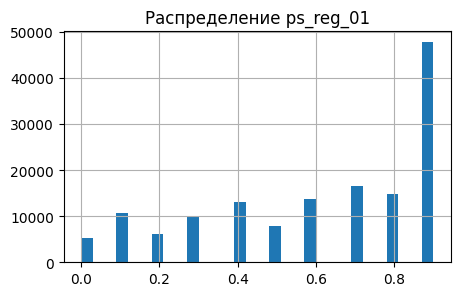

In [36]:
import matplotlib.pyplot as plt

# пример числового признака
col_num = "ps_reg_01"

plt.figure(figsize=(5,3))
df[col_num].replace(-1, None).dropna().hist(bins=30)
plt.title(f"Распределение {col_num}")
plt.show()


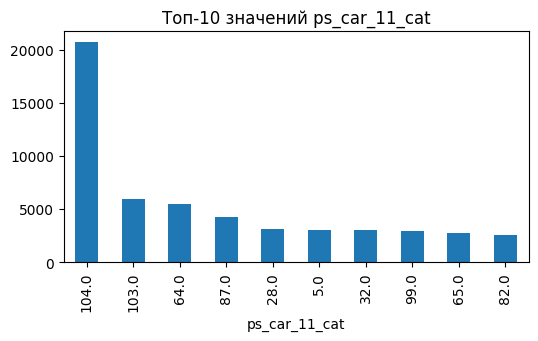

In [37]:
col_cat = "ps_car_11_cat"

vc = df[col_cat].replace(-1, None).dropna().value_counts().head(10)

plt.figure(figsize=(6,3))
vc.plot(kind="bar")
plt.title(f"Топ-10 значений {col_cat}")
plt.show()


In [38]:
import numpy as np

# Временно заменяем -1 на NaN, чтобы корреляция считалась корректно
df_corr = df.replace(-1, np.nan)

# Берем только числовые столбцы
corr = df_corr.corr(numeric_only=True)

# Корреляция с target
corr_target = corr["target"].abs().sort_values(ascending=False)

print("Топ-10 признаков по |корреляции| с target:")
print(corr_target.iloc[1:11])  # первый — это сам target


Топ-10 признаков по |корреляции| с target:
ps_car_13        0.056233
ps_car_12        0.039969
ps_ind_05_cat    0.036916
ps_reg_03        0.035861
ps_reg_02        0.035486
ps_ind_06_bin    0.035197
ps_car_02_cat    0.034968
ps_ind_17_bin    0.034927
ps_car_04_cat    0.033401
ps_ind_07_bin    0.032638
Name: target, dtype: float64


In [39]:
# id — это просто идентификатор строки, модели он не помогает
if "id" in df.columns:
    df = df.drop(columns=["id"])


In [40]:
import numpy as np

# Заменяем -1 на NaN
df = df.replace(-1, np.nan)


In [41]:
# X — все признаки
X = df.drop(columns=["target"])

# y — целевая переменная
y = df["target"]


In [42]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [43]:
print("Размеры выборок:")
print("Train:", X_train.shape)
print("Valid:", X_valid.shape)

print("\nДоля target=1:")
print("Train:", y_train.mean())
print("Valid:", y_valid.mean())


Размеры выборок:
Train: (116703, 56)
Valid: (29176, 56)

Доля target=1:
Train: 0.036717136663153474
Valid: 0.03670825335892514


In [44]:
# Заполняем NaN отдельно для train и valid
for col in X_train.columns:
    if X_train[col].dtype in ["float64", "int64"]:
        median = X_train[col].median()
        X_train[col] = X_train[col].fillna(median)
        X_valid[col] = X_valid[col].fillna(median)


In [50]:
# Копируем обучающие данные, чтобы не менять оригинальные
X_train_lr = X_train.copy()
X_valid_lr = X_valid.copy()
# Заполняем пропуски NaN медианами по обучающей выборке
medians = X_train_lr.median(numeric_only=True)
X_train_lr = X_train_lr.fillna(medians)
X_valid_lr = X_valid_lr.fillna(medians)
# Инициализируем логистическую регрессию с балансировкой классов
lr_model = LogisticRegression(class_weight='balanced', max_iter=2000,
n_jobs=-1, random_state=42)
# Обучаем модель на обучающей выборке
lr_model.fit(X_train_lr, y_train)
print("Логистическая регрессия обучена ✔")


Логистическая регрессия обучена ✔


In [52]:
# Предсказываем вероятности класса 1 на валидации
y_valid_proba = lr_model.predict_proba(X_valid_lr)[:, 1]
# Считаем метрики качества
auc = roc_auc_score(y_valid, y_valid_proba)
gini = 2 * auc - 1 # коэффициент Джини
print(f"ROC-AUC: {auc:.5f}")
print(f"Gini: {gini:.5f}")


ROC-AUC: 0.61847
Gini: 0.23694


In [53]:
# Преобразуем вероятности в метки при пороге 0.5
y_valid_pred = (y_valid_proba >= 0.5).astype(int)
# Вычисляем Precision, Recall, F1 для класса 1
precision = precision_score(y_valid, y_valid_pred, zero_division=0)
recall = recall_score(y_valid, y_valid_pred, zero_division=0)
f1 = f1_score(y_valid, y_valid_pred, zero_division=0)
print(f"Precision (class=1): {precision:.5f}")
print(f"Recall (class=1): {recall:.5f}")
print(f"F1-score (class=1): {f1:.5f}")


Precision (class=1): 0.05145
Recall (class=1): 0.53408
F1-score (class=1): 0.09386


Confusion Matrix:
[[17559 10546]
 [  499   572]]


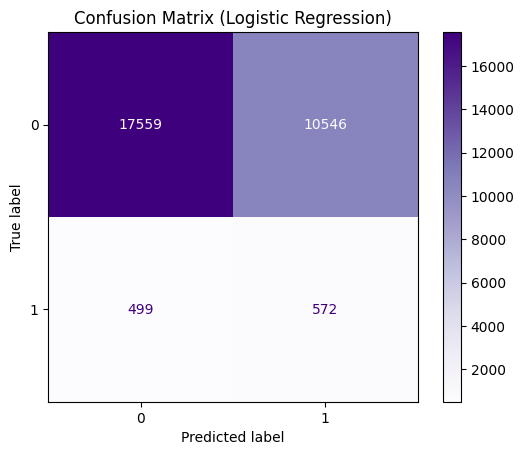

In [54]:
# Матрица ошибок на валидации
cm = confusion_matrix(y_valid, y_valid_pred)
print("Confusion Matrix:")
print(cm)
2
# Визуализируем матрицу ошибок в виде графика
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Purples')
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

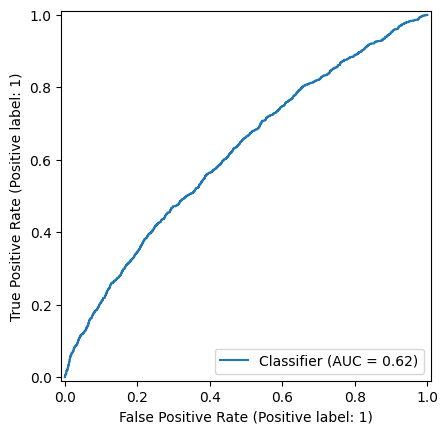

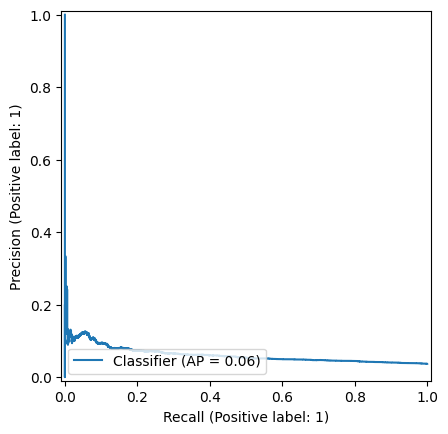

In [55]:
RocCurveDisplay.from_predictions(y_valid, y_valid_proba)
PrecisionRecallDisplay.from_predictions(y_valid, y_valid_proba)


In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

param_grid = {
    "n_estimators": [120, 200],
    "max_depth": [5, 10],
    "min_samples_leaf": [1, 5],
}

rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    max_samples=0.7
)

grid = GridSearchCV(
    rf,
    param_grid=param_grid,
    cv=2,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

start_time = time.time()
grid.fit(X_train, y_train)
elapsed = time.time() - start_time

print("Лучшие параметры RF:", grid.best_params_)
print("Лучший AUC на CV:", grid.best_score_)
print(f"Время подбора RF (сек): {elapsed:.2f}")



Fitting 2 folds for each of 8 candidates, totalling 16 fits
Лучшие параметры RF: {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 200}
Лучший AUC на CV: 0.6190280819063683
Время подбора RF (сек): 158.83


In [64]:
# Извлекаем лучшую модель случайного леса после GridSearch
best_rf_model = grid.best_estimator_
# Предсказываем вероятности и метки на валидации
y_valid_proba_rf = best_rf_model.predict_proba(X_valid)[:, 1]
y_valid_pred_rf = (y_valid_proba_rf >= 0.5).astype(int)
# Вычисляем метрики на валидационной выборке
auc_rf = roc_auc_score(y_valid, y_valid_proba_rf)
gini_rf = 2 * auc_rf - 1
prec_rf = precision_score(y_valid, y_valid_pred_rf, zero_division=0)
rec_rf = recall_score(y_valid, y_valid_pred_rf, zero_division=0)
f1_rf = f1_score(y_valid, y_valid_pred_rf, zero_division=0)
print(f"RandomForest Gini: {gini_rf:.3f}, F1: {f1_rf:.3f}, Precision: {prec_rf:.3f}, Recall: {rec_rf:.3f}")

RandomForest Gini: 0.237, F1: 0.095, Precision: 0.052, Recall: 0.515


In [70]:
!pip install optuna lightgbm -q

import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

def objective(trial):
    num_leaves = trial.suggest_int("num_leaves", 20, 64)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 3, 8)

    model = LGBMClassifier(
        is_unbalance=True,
        n_estimators=200,
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42,
        n_jobs=-1
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="auc",
        callbacks=[
            lgb.early_stopping(stopping_rounds=20),
            lgb.log_evaluation(period=0)
        ]
    )

    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_pred_proba)


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=20, show_progress_bar=True)

print(f"Лучший AUC: {study.best_value:.5f}")
print(f"Лучшие параметры: {study.best_params}")


[I 2025-12-29 11:18:58,509] A new study created in memory with name: no-name-de02eac6-c912-465f-a09d-02da1b06f0cc


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4285, number of negative: 112418
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 116703, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036717 -> initscore=-3.267104
[LightGBM] [Info] Start training from score -3.267104
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.612177	valid_0's binary_logloss: 0.701352
[I 2025-12-29 11:18:59,884] Trial 0 finished with value: 0.6121766431769886 and parameters: {'num_leaves': 36, 'learning_rate': 0.2536999076681772, 'max_depth': 7}. Best is trial 0 with value: 0.6121766431769886.
[LightGBM] [Info] Number of positive: 4285, number of negative: 11241